<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<h1 align=left><font size = 8, style="color:rgb(200,0,0)"><b>Deep Learning</b></font></h1> 
<a href="mailto:rogerio.oliveira@mackenzie.br">Rogério de Oliveira</a><br>

<br>
<br>

---


# Exemplos PyTorch

Vamos então analisar 3 casos de uso de Autoencoders com PyTorch. 

- Autoencoder Feedforward para supressão de ruído
- Autoencoder Feedforward para geração de novos casos
- Autoencoder Convolucional para geração de novos casos

Em todos os casos vamos trabalhar com as imagens de dígitos do MNIST.

Um **exemplo similar em TensorFlow** para a parte de eliminação de ruído pode ser obtida [aqui](https://github.com/rasbt/stat479-deep-learning-ss19/blob/master/L15_autoencoder/code/ae-simple.ipynb)

# Importando o PyTorch e os dados de MNIST

As imagens são normalizadas e são empregados lotes de 64 imagens para o aprendizado.

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transform
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import math


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
batch_size = 64
img_transform = transform.Compose([transform.ToTensor(), transform.Normalize((0.5,),(0.5,))]) 

train_set = torchvision.datasets.MNIST(root = 'data', train= True, transform= img_transform, download= True)
test_set = torchvision.datasets.MNIST(root = 'data', train= False, transform= img_transform, download= True)

img, _ = train_set[0]

train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_set, batch_size=batch_size, shuffle=False)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



102.8%


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



100.0%


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable



112.7%

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

Processing...
Done!



/home/pbraga/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Autoencoder Feedforward e Supressão de Ruído

## Definido a rede

É útil separar as funções de Encoder e Decoder pois você vai empregá-las depois separadamente.

> **Verifique você:** Quantas camadas e qual o tamanho do espaço latente aqui produzidos? 

In [4]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.f1 = nn.Linear(28*28,196)
        self.f2 = nn.Linear(196,49)
        self.f3 = nn.Linear(49,7)

    def forward(self, image):
        out = F.relu(self.f1(image))
        out = F.relu(self.f2(out))
        z = F.relu(self.f3(out))
        return z

class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.f1 = nn.Linear(7,49)
        self.f2 = nn.Linear(49,196)
        self.f3 = nn.Linear(196,28*28)

    def forward(self, z):
        out = F.relu(self.f1(z))
        out = F.relu(self.f2(out))
        out = torch.tanh(self.f3(out))
        return out
 
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder,self).__init__()
        self.Encoder = Encoder()
        self.Decoder = Decoder()

    def forward(self, image):
        z = self.Encoder(image)
        out =  self.Decoder(z)
        return out    


## Definindo o Treinamento

Aqui estamos treinando um modelo para supressão de ruído. 

> **Verifique você:** 
> - Quem são as entradas e saídas da rede? Existe adição de ruído em algum lugar deste código? 
> - O que faz o comando `to(device)`? 
> - O que faz o comando `train_loss_avg[-1] /= num_batches`?

Essa etapa é importante e pode mudar de acordo com a tarefa para que estamos empregando o Autoencoder.

In [5]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
        train_loss_avg.append(0)
        num_batches = 0
    
        for img, _ in train_loader:

            img_original = img.view(img.size(0),-1).to(device)

            img = img + torch.randn(img.size()) * 0.01 + 0.1
            img = img.view(img.size(0),-1)
            img = img.to(device)
            print(img.shape)

            img_recon = model(img)
            loss = loss_fn(img_recon, img_original)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_avg[-1] += loss.item()
            num_batches += 1
          
        train_loss_avg[-1] /= num_batches
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg

## Executando o Treinamento

> **Verifique você:** 
> - O que é a função `model()` do treinamento que estamos executando?


In [6]:
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)
autoencoder.train()
loss_values = train(autoencoder, train_loader, 10, loss) # use 20



torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size([64, 784])
torch.Size

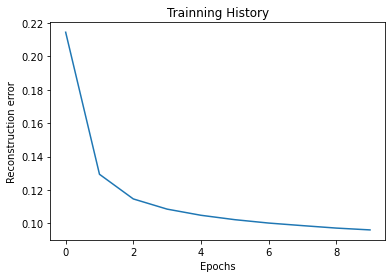

In [12]:
fig = plt.figure()
plt.plot(loss_values)
plt.xlabel('Epochs')
plt.ylabel('Reconstruction error')
plt.title('Trainning History')
plt.show()

## Inspecionando os resultados

> **Verifique você:** 
> - Para que serve `with torch.no_grad():`?
> - Explore o código para ver diferentes níveis de ruído na imagem e sua reconstrução.

> Aqui somente uma função para exibição dos dados.

In [18]:
def Show(out):

  # decorations... rs
  ax = plt.axes()
  ax.set(facecolor = "orange")

  grid = torchvision.utils.make_grid(out)
  plt.imshow(transform.ToPILImage()(grid),alpha=0.75)

  # decorations... rs
  plt.xticks([])
  plt.yticks([])
  plt.show()

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
Entradas


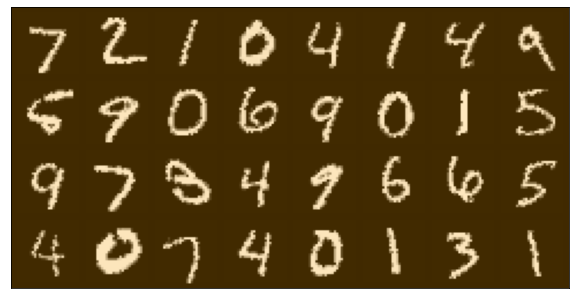

Entradas com Ruído


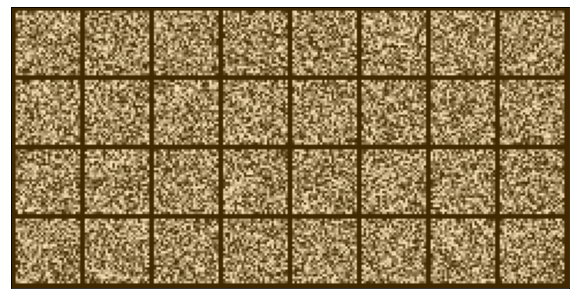

Saída Reconstruída


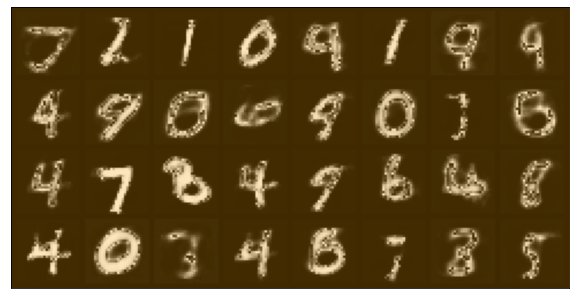

In [28]:
with torch.no_grad():

  image1,label = iter(test_loader).next()   
  print(label[0:32])
  image = image1 + torch.randn(image1.size()) * 1.9 + 0.1
  
  image = image.to(device)
  image = image.view(image.size(0),-1)
  saida = autoencoder(image)
  saida = saida.view(saida.size(0),1,28,28)
  
  print("Entradas")
  image1 = image1.view(image1.size(0),1,28,28)
  fig, ax = plt.subplots(figsize=(10, 10))
  Show(image1[0:32])
  plt.show()
    
  print("Entradas com Ruído")
  image = image.view(image.size(0),1,28,28)
  fig, ax = plt.subplots(figsize=(10, 10))
  Show(image[0:32])
  plt.show()

  print("Saída Reconstruída")
  fig, ax = plt.subplots(figsize=(10, 10))
  Show(saida[0:32])
  plt.show()

# Autoencoder Feedforward para geração de novos casos

> **Verifique você:** 
> - O que faz a instrução `z = torch.randn(128, 7)*std + mean`?

Exemplos Reais


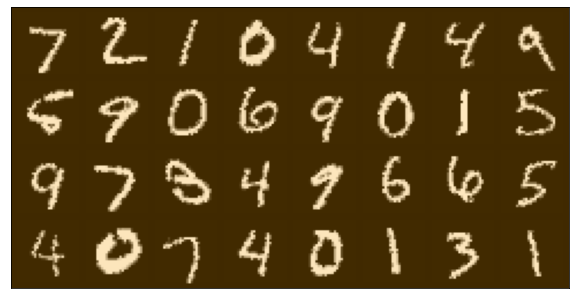

Imagens Geradas


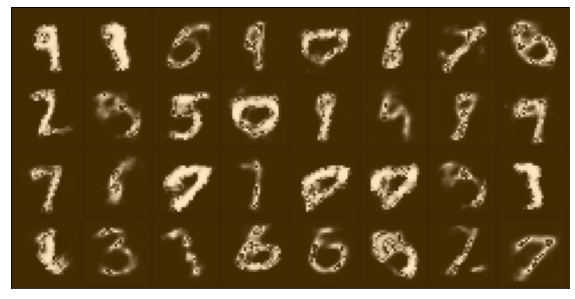

In [29]:
with torch.no_grad():
    img, _ = iter(test_loader).next()
    img = img.to(device)
    img = img.view(img.size(0),-1)


    z = autoencoder.Encoder(img)
    z = z.to('cpu')

    print("Exemplos Reais")
    img = img.view(img.size(0),1,28,28)
    fig, ax = plt.subplots(figsize=(10, 10))
    Show(img[0:32])
    plt.show()

    mean = z.mean(dim=0)
    std = (z - mean).pow(2).mean(dim=0).sqrt()

    z = torch.randn(128, 7)*std + mean
    z = z.to(device)
    saida = autoencoder.Decoder(z)

    print("Imagens Geradas")
    saida = saida.view(saida.size(0),1,28,28)
    fig, ax = plt.subplots(figsize=(10, 10))
    Show(saida[0:32])
    plt.show()
 

# Autoencoder Convolucional para geração de novos casos

> **Verifique você:** Quantas camadas e qual o tamanho do espaço latente aqui produzidos? 


In [30]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=4, stride=2, padding=1)
    self.conv2 = nn.Conv2d(in_channels=64, out_channels=64*2, kernel_size=4, stride=2, padding=1)
    self.fc = nn.Linear(in_features=64*2*7*7, out_features=10)

  def forward(self, image):
    out = F.relu(self.conv1(image))
    out = F.relu(self.conv2(out))
    out = out.view(out.size(0), -1)
    z = self.fc(out)
    return z

class Decoder(nn.Module):
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc    = nn.Linear(in_features=10,out_features=2*64*7*7)
    self.convTran1 = nn.ConvTranspose2d(in_channels=2*64,out_channels=64, kernel_size=4, stride=2, padding=1)
    self.convTran2 = nn.ConvTranspose2d(in_channels=64,out_channels=1, kernel_size=4, stride=2, padding=1)
   
  def forward(self, latent):
    out = self.fc(latent)
    out = out.view(out.size(0), 64*2, 7, 7)
    out = F.relu(self.convTran1(out))
    out = torch.tanh(self.convTran2(out))
    return out

class Autoencoder(nn.Module):
   def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

   def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return  x_recon
          

In [31]:
def train(model, train_loader, Epochs, loss_fn):
    train_loss_avg = []
    for epoch in range(Epochs):
      train_loss_avg.append(0)
      num_batches = 0
    
      for image_batch, _ in train_loader:
          
          image_batch = image_batch.to(device)
          
          image_batch_recon = model(image_batch)
          loss = loss_fn(image_batch_recon, image_batch)
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          
          train_loss_avg[-1] += loss.item()
          num_batches += 1
          
      train_loss_avg[-1] /= num_batches
      print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, Epochs, train_loss_avg[-1]))
    return train_loss_avg

In [33]:
capacity = 64
latent_dims = 10    
learning_rate = 0.001
autoencoder = Autoencoder()
autoencoder.to(device)
loss = nn.MSELoss()
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=learning_rate, weight_decay=1e-5)

autoencoder.train()

loss_result = train(autoencoder,train_loader,10,loss) # empregue 20

Epoch [1 / 10] average reconstruction error: 0.095942
Epoch [2 / 10] average reconstruction error: 0.065256
Epoch [3 / 10] average reconstruction error: 0.059990
Epoch [4 / 10] average reconstruction error: 0.057094
Epoch [5 / 10] average reconstruction error: 0.055168
Epoch [6 / 10] average reconstruction error: 0.053889
Epoch [7 / 10] average reconstruction error: 0.052916
Epoch [8 / 10] average reconstruction error: 0.052104
Epoch [9 / 10] average reconstruction error: 0.051491
Epoch [10 / 10] average reconstruction error: 0.050957


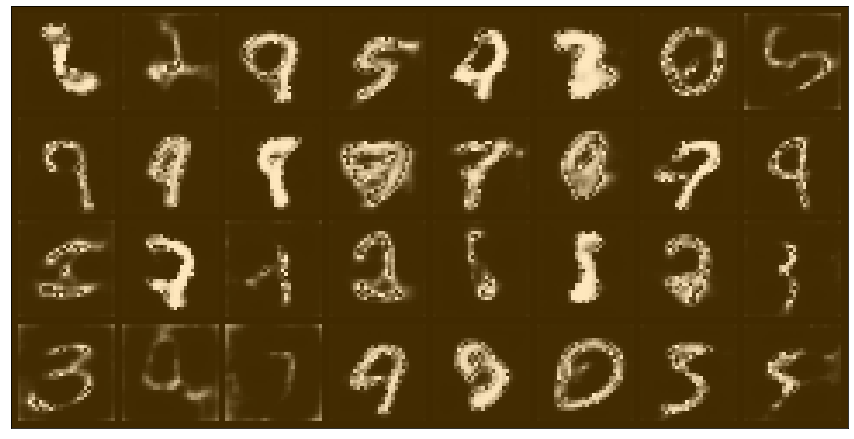

In [34]:
autoencoder.eval()

tensor = torch.zeros(len(test_loader),10)

with torch.no_grad():

  image,label = iter(test_loader).next()
  image = image.to(device)
  z = autoencoder.encoder(image)
  z = z.to('cpu')
  mean = z.mean(dim=0)

  std = (z - mean).pow(2).mean(dim=0).sqrt()
  
  z = torch.randn(128, latent_dims)*std + mean
  
  z = z.to(device)
  decodificado = autoencoder.decoder(z)
 
  decodificado = decodificado.to('cpu')

  fig, ax = plt.subplots(figsize=(15, 15))
  Show(decodificado[0:32])
  plt.show()



# Exercício

Para entrega no Moodle.

> A. Empregue este código e crie um modelo semelhante a supressão de ruído e criação de imagens a partir do conjunto de dados CIFAR10. (Semana 1)

> B. Empregue treine um modelo de Autoenconder Variacional somente com as imagens de gatos e produza novas imagens de 'gatos'. (Semana 2)